In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from kevin_utils2 import *


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [4]:
import gzip
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df1 = getDF('reviews_Beauty.json.gz')

In [70]:
df=df1

In [71]:
df=df.dropna(axis=1,how='any')

In [72]:
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A39HTATAQ9V7YF,0205616461,"[0, 0]",i do love this moisturizer and would recommend...,5.0,bio-active anti-aging serum,1369699200,"05 28, 2013"
1,A3JM6GV9MNOF9X,0558925278,"[0, 1]",I received this product before the deadline.I ...,3.0,"This product is ok, I'm use Baby Kabuki in moment",1355443200,"12 14, 2012"
2,A1Z513UWSAAO0F,0558925278,"[0, 0]",I love this set. Great buy for the price. I do...,5.0,I love this set,1404691200,"07 7, 2014"
3,A1WMRR494NWEWV,0733001998,"[0, 0]","A nice moisturizer, all natural ingredients an...",4.0,Nice Moisturizer,1382572800,"10 24, 2013"
4,A3IAAVS479H7M7,0737104473,"[2, 2]",Please research the MAC Hello Kitty collection...,1.0,Fake MAC,1274227200,"05 19, 2010"


## Create features


Rather than do one-hot encodings for the categorical variables I will be using embeddings 

Rather than do one-hot encodings for the categorical variables I will be using embeddings 

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023070 entries, 0 to 2023069
Data columns (total 8 columns):
reviewerID        object
asin              object
helpful           object
reviewText        object
overall           float64
summary           object
unixReviewTime    int64
reviewTime        object
dtypes: float64(1), int64(1), object(6)
memory usage: 138.9+ MB


In [74]:
cat_var_dict = {'reviewerID': 20, 'asin': 20}

In [75]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [76]:
len(cat_vars)

2

In [77]:
joined=df

In [78]:
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [79]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]


In [80]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

2

In [81]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1210271, 249274]

In [82]:
n = len(df)

## Sample Data


In [83]:
samp_size = 300000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [84]:
joined_sample = df.iloc[idxs]

In [85]:
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

In [86]:
joined_valid = joined_sample[train_size:]
joined_train = joined_sample[:train_size]
len(joined_valid), len(joined_train)

(60000, 240000)

In [87]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [88]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

In [89]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [90]:
y_train_orig = joined_train.overall
y_valid_orig = joined_valid.overall

In [91]:
max_log_y = np.max(np.log(joined_sample.overall))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

In [92]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [93]:
def normalize_inv(preds):
    return preds * ystd + ymean

In [94]:
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

In [95]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

##xgboost

In [96]:
X_train = np.concatenate([cat_map_train], axis=1)

In [97]:
X_valid = np.concatenate([cat_map_valid], axis=1)

In [98]:
all_vars = cat_vars 

In [99]:
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.8, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [100]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)

In [101]:
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)

In [102]:
xgb_parms['seed'] = random.randint(0,1e9)
model = xgboost.train(xgb_parms, xdata)

In [103]:
model.eval(xdata_val)

b'[0]\teval-rmse:0.335422'

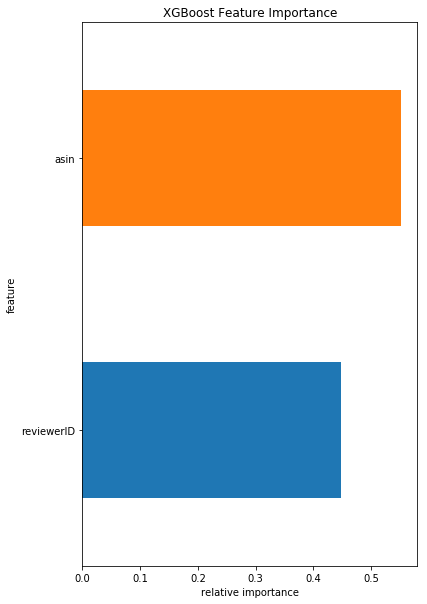

In [104]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');